# Remote parallel inversion [distributed]

Demo of working inversion (from `grad.ini`) | Brendan Smithyman | May 14, 2015

In [1]:
# profile = 'phobos'   # remote workstation
# profile = 'pantheon' # remote cluster
# profile = 'zeus' # remote workstation
profile = 'mpi' # local machine

In [2]:
from pygeo.segyread import SEGYFile
from pygeo.fullpy import readini

In [3]:
import numpy as np
from zephyr.Dispatcher import SeisFDFDDispatcher
from zephyr.Parallel import CommonReducer
from IPython.parallel import Reference

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 150 # Change this to adjust figure size

# Plotting options
font = {
    'family': 'Bitstream Vera Sans',
    'weight': 'normal',
    'size': 8,
}

matplotlib.rc('font', **font)

In [5]:
lclip = 2000
hclip = 3000
clipscale = 0.1
sms = 0.5
rms = 0.5

def plotField(u):
    clip = clipscale*abs(u).max()
    plt.imshow(u.real, cmap=cm.bwr, vmin=-clip, vmax=clip)

def plotModel(v):
    plt.imshow(v.real, cmap=cm.jet, vmin=lclip, vmax=hclip)

def plotGeometry(geom):
    
    srcpos = geom['src'][:,::2]
    recpos = geom['rec'][:,::2]
    
    axistemp = plt.axis()
    plt.plot(srcpos[:,0], srcpos[:,1], 'kx', markersize=sms)
    plt.plot(recpos[:,0], recpos[:,1], 'kv', markersize=rms)
    plt.axis(axistemp)

# Setup

Input files:

In [6]:
configFile  = 'grad.ini'
trueModel   = 'grad.vp.true'
startModel  = 'grad.vp.start'
geom2D      = True

Reading configuration & models:

In [7]:
cTrue = SEGYFile(trueModel)[:].astype(np.float64)#[25:-25,6:-6].astype(np.float64)
cFlat = SEGYFile(startModel)[:].astype(np.float64)
ini = readini(configFile)

Parameters not set in *.ini* file:

In [8]:
freeSurf    = [False, False, False, False] # t r b l
nPML        = 10            # number of PML points
density     = 2700          # units of density
Q           = np.inf        # can be inf

cache       = False         # whether to cache computed wavefields for a given source
cacheDir    = '.'

parFac = 1
chunksPerWorker = 1        # NB: parFac * chunksPerWorker = number of source array subsets
ensembleClear = False

In [9]:
rho         = np.ones(cTrue.shape) * density

if geom2D:
    geom        = {
        'src':  np.array([ini['srcs'][:,0], np.zeros(ini['ns']), ini['srcs'][:,1]]).T,
        'rec':  np.array([ini['recs'][:,0], np.zeros(ini['nr']), ini['recs'][:,1]]).T,
        'mode': 'fixed',
    }
else:
    geom        = {
        'src':  ini['srcs'],
        'rec':  ini['recs'],
        'mode': 'fixed',
    }

systemConfig = {
    'dx':       ini['dx'],  # m
    'dz':       ini['dz'],  # m
    'c':        cTrue.T,    # m/s
    'rho':      rho.T,      # density
    'Q':        Q,          # can be inf
    'nx':       ini['nx'],         # count
    'nz':       ini['nz'],         # count
    'freeSurf': freeSurf,   # t r b l
    'nPML':     nPML,
    'geom':     geom,
    'cache':    cache,
    'cacheDir': cacheDir,
    'freqs':    ini['freqs'],
    'nky':      ini['nky'],
    'parFac':   parFac,
    'chunksPerWorker':  chunksPerWorker,
    'profile':  profile,
    'ensembleClear':    ensembleClear,
#     'MPI': False,
#    'Solver':   Reference('SimPEG.SolverWrapD(scipy.sparse.linalg.splu)'),#Solver,
}

In [10]:
%%time
sp = SeisFDFDDispatcher(systemConfig)

CPU times: user 125 ms, sys: 14.8 ms, total: 139 ms
Wall time: 277 ms


Forward modelling 'true' data (in parallel)

In [11]:
%%time
sp.forward()
dObs = sp.dPred
sp.dObs = dObs

CPU times: user 243 ms, sys: 43.7 ms, total: 287 ms
Wall time: 1.85 s


Inverting using new `inversion` wrapper, and canned solver (`fmin_cg`, `fmin_l_bfgs_b`, or `fmin_ncg`)

In [12]:
%%time
import inversion
reload(inversion)
sim = inversion.SeisInverseProblem(sp, cFlat.T)
res = sim(solver=inversion.fmin_ncg, maxiter=5)

It.	Misfit		fn Eval.
			6.02e+03
  0	6.02e+03
			5.13e+03
			5.69e+03
			2.44e+03
  1	2.44e+03
Optimization terminated successfully.
         Current function value: 2436.819733
         Iterations: 1
         Function evaluations: 2
         Gradient evaluations: 6
         Hessian evaluations: 0
CPU times: user 6.21 s, sys: 806 ms, total: 7.01 s
Wall time: 32.8 s


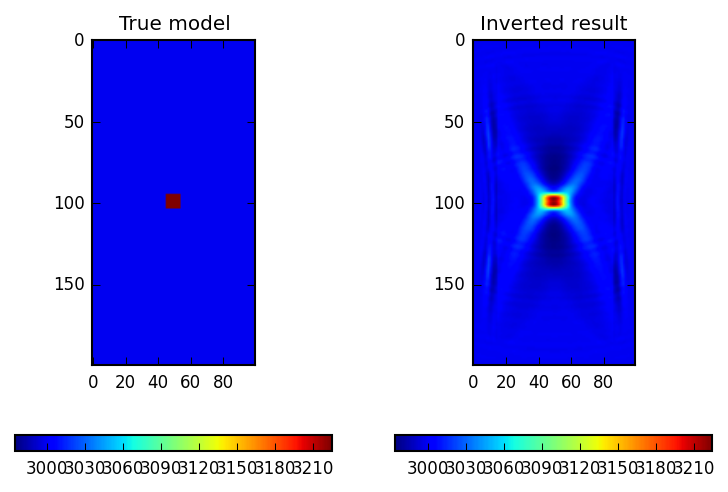

In [13]:
vel = 1./(res[0] if type(res) is tuple else res).reshape(cTrue.T.shape)

plt.subplot(1,2,1)
plt.imshow(cTrue.T, vmin=vel.min(), vmax=vel.max())
plt.colorbar(orientation='horizontal')
plt.title('True model')

plt.subplot(1,2,2)
plt.imshow(vel)
plt.colorbar(orientation='horizontal')
plt.title('Inverted result')